# **Modelling and Evaluating - RGB**

## Objectives
To develop, train, and evaluate a machine learning model for image classification, incorporating image augmentation and comprehensive performance analysis through various metrics and visualizations. The objective includes modifying class indices, plotting augmented images, creating and summarizing the model, and saving the trained model. Model performance will be assessed using accuracy, ROC curves, and classification reports, followed by plotting the confusion matrix and saving the evaluation results. The final output will also involve making predictions on a random image file.

## Inputs
* Images are taken from the test, train, validation folders and their subfolders.
```
└───inputs/ 
    └───potato_disease_dataset/ 
        ├───test/
        │   ├───healthy
        │   ├───early_blight
        │   └───late_blight                   
        ├───train/
        │   ├───healthy
        │   ├───early_blight
        │   └───late_blight          
        └───validation/
            ├───healthy
            ├───early_blight
            └───late_blight               
```
* Image shape embeddings.


## Outputs
- Image augmentation.
    - Plot augmented images for each dataset.
- Modify class indices to alter prediction in labels.
- Create a machine learning model and display its summary.
    - Train the model.
    - Save the model.
    - Plot the learning curve to show model performance.
        - Model A - generate separate plots for accuracy and loss.
        - Model B - create a comprehensive model history plot.
        - Model C - visualize model history using Plotly.
- Evaluate the model using a saved file.
    - Calculate accuracy.
    - Plot the ROC curve.
    - Generate a classification report for Model A.
    - Model B - provide a classification report including macro average and weighted average.
    - Model C - produce a synthetic classification report per label.
- Plot the confusion matrix.
- Save the evaluation results in a pickle file.
- Predict on a random image file.

---

## Import necessary packages for this notebook

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import joblib

%matplotlib inline


---

## Set Working Directory

As the notebooks are within a subfolder, we will need to change the working directory when running the notebook in the editor.

We need to change the working directory from its current folder to its parent folder.
* We access the current directory with `os.getcwd()`

In [2]:
current_dir = os.getcwd()
current_dir

'/workspace/ci-ms5-spudscan/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.
* `os.path.dirname()` gets the parent directory
* `os.chir()` defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory.

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/ci-ms5-spudscan'

---

## Set input directory
Set train, validation and test paths.

In [5]:
my_data_dir = 'inputs/potato_disease_dataset'
train_path = my_data_dir + '/train' 
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

print("Train path:", train_path)
print("Validation path:", val_path)
print("Test path:", test_path)

Train path: inputs/potato_disease_dataset/train
Validation path: inputs/potato_disease_dataset/validation
Test path: inputs/potato_disease_dataset/test


---

## Set output directory

Change the version number below to change output dir.

In [6]:
version = 'v2'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


---

## Set Label Names

In [7]:
labels = os.listdir(train_path)
print('Labels for the images are', labels)

Labels for the images are ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


---

### Set image shape

In [8]:
# Import saved image shape embedding
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Image data augmentation

### Initialize ImageDataGenerator

In [9]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Set Batch Size

In [10]:
batch_size = 16

### Augment datasets

#### Augment training image set

In [11]:
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 1506 images belonging to 3 classes.


{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}

#### Augment validation image set

In [12]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 213 images belonging to 3 classes.


{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}

#### Augment test image set

In [13]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 433 images belonging to 3 classes.


{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}

### Plot augmented datasets

#### Plot augmented training image set

(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)


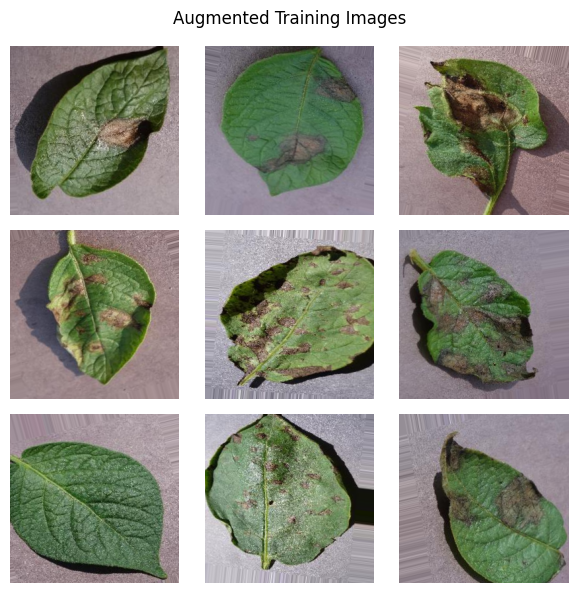

In [15]:
# Create a 3x3 grid for displaying images
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6, 6))

# Loop through each cell in the grid
for i in range(3):
    for j in range(3):
        # Get the next image and label from the training set
        img, label = train_set.next()
        print(img.shape)  # Print the shape of the image
        
        # Display the image in the corresponding cell
        axes[i, j].imshow(img[0])
        axes[i, j].axis('off')  # Hide the axis

# Show the plot
plt.tight_layout()
plt.show()

#### Plot augmented validation image set

(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)


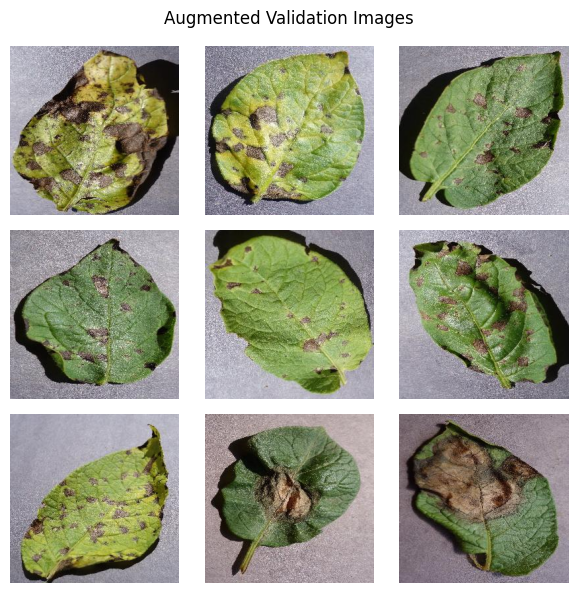

In [16]:
# Create a 3x3 grid for displaying images
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6, 6))

# Loop through each cell in the grid
for i in range(3):
    for j in range(3):
        # Get the next image and label from the training set
        img, label = validation_set.next()
        print(img.shape)  # Print the shape of the image
        
        # Display the image in the corresponding cell
        axes[i, j].imshow(img[0])
        axes[i, j].axis('off')  # Hide the axis

# Show the plot
plt.tight_layout()
plt.show()

### Plot augmented test image set

(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)


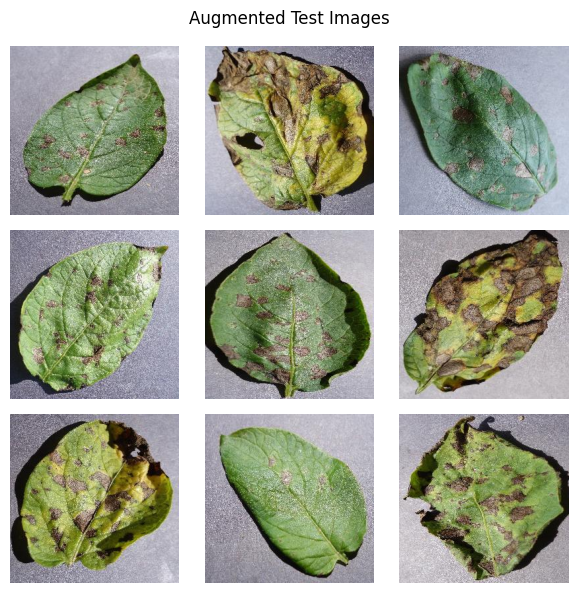

In [17]:
# Create a 3x3 grid for displaying images
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6, 6))

# Loop through each cell in the grid
for i in range(3):
    for j in range(3):
        # Get the next image and label from the training set
        img, label = test_set.next()
        print(img.shape)  # Print the shape of the image
        
        # Display the image in the corresponding cell
        axes[i, j].imshow(img[0])
        axes[i, j].axis('off')  # Hide the axis

# Show the plot
plt.tight_layout()
plt.show()

### Save class indices

In [18]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v2/class_indices.pkl']

---